Update of the needed packages

In [ ]:
using Revise
using Pkg
using BifurcationKit, LinearAlgebra, Plots, SparseArrays, Parameters, Setfield
const BK = BifurcationKit
push!(LOAD_PATH, pwd())
includet("FunGel.jl")
using LaTeXStrings

Definition of functions:
 - Fun: Functional that implicitly defines the solution
 - height: Compute the size of the gel
 - totalcharge: Compute the net charge at each spatial location

In [21]:
function Fun(X,p)
    @unpack β,ω,OpDxx,OpDx,par= p
    nx= par["nx"]
    par["beta"]=10^(β)
    par["omega"]=10^(ω)
    N = reshape(X[1:end-1],nx+1,4)
    H = X[end]
   
    return Main.CPDE.wrap_F(N[:,1],N[:,2],N[:,3],N[:,4],H,OpDxx,OpDx,par) 
end

function height(X)
    return 1/X[end]
end
function totalcharge(X,Nx,par)
    c0=par["c0"]
    chi=par["chi"]
    alf=par["alf"]
    ps=X[1:Nx+1]
    pn=X[Nx+2:2*Nx+2]
    Phi=X[2*Nx+3:3*Nx+3]

    B=X[3*Nx+4:4*Nx+4]
    fac=2*ps*c0/(1-2*c0).*exp.(chi.*pn-B)

    return (alf.*pn-fac.*sinh.(Phi))
    
end

totalcharge (generic function with 1 method)

Computation of the initial solution for the continuation

In [83]:
Nx=400
XX=range(0,stop=Nx,length=Nx+1)/Nx
dic,OpD1,OpD2 = Main.CPDE.init_par(Nx);
sol0 = Main.CPDE.formInitialGuess(dic,Nx);

par_mod = (β=-3.0,ω=-2.0,OpDxx=OpD1,OpDx=OpD2,par=dic);
opt_newton = NewtonPar(tol = 1e-12, verbose = true, maxIter = 50)
out, _, _ = @time BK.newton(Fun,out, par_mod, opt_newton);

Control that the solution is physical by plotting

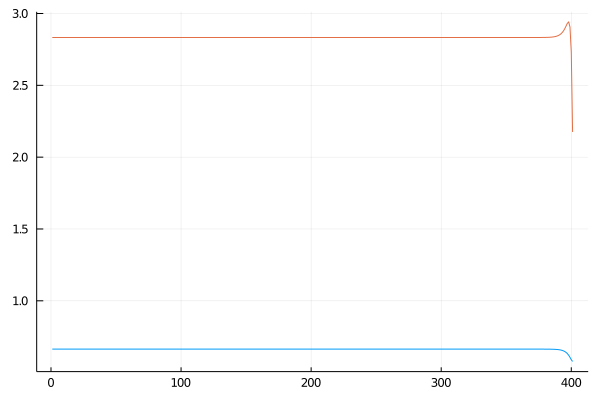

In [85]:
plot(out[1:Nx+1],legend=false)
plot!(out[2*Nx+3:3*Nx+3],legend=false)


Continuation of the solution branch

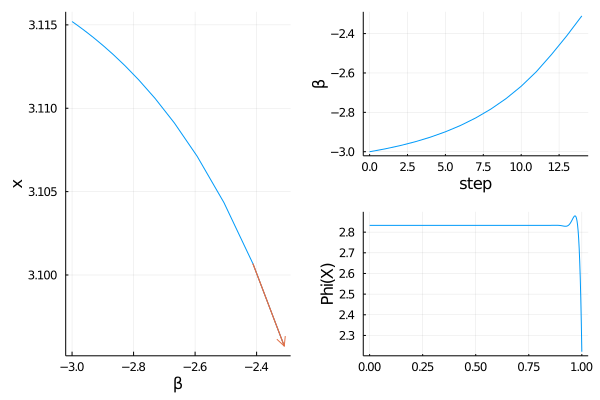

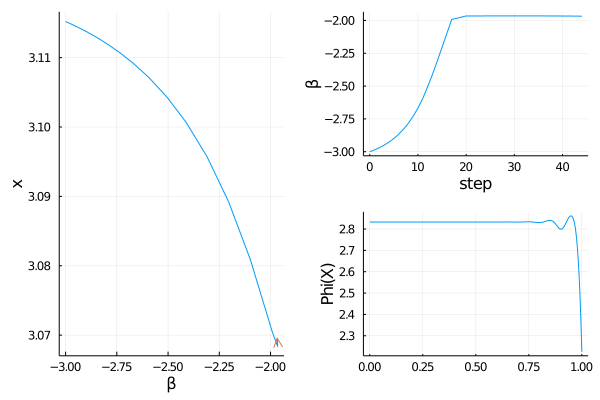

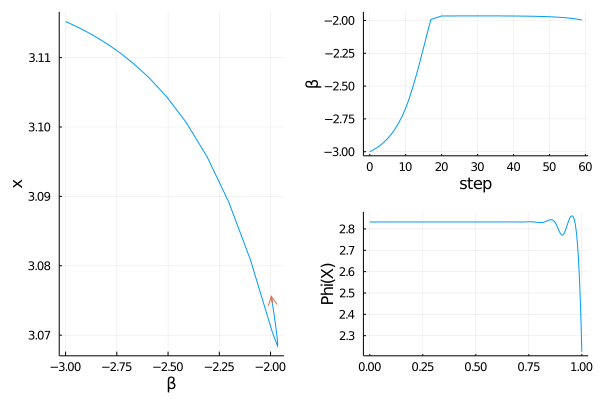

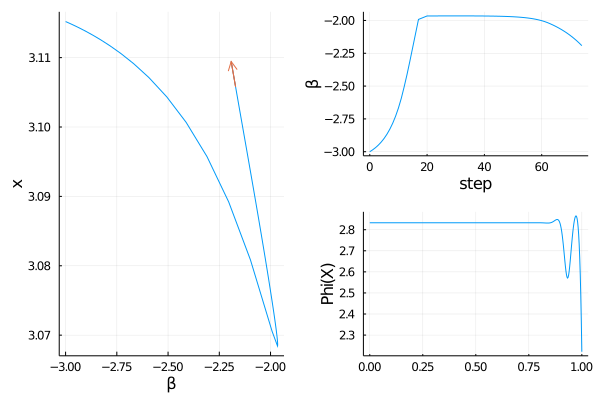

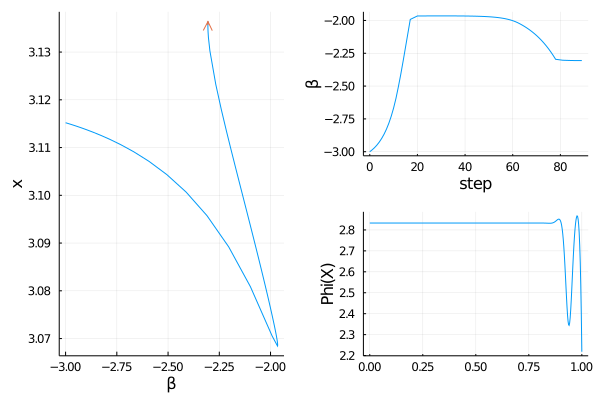

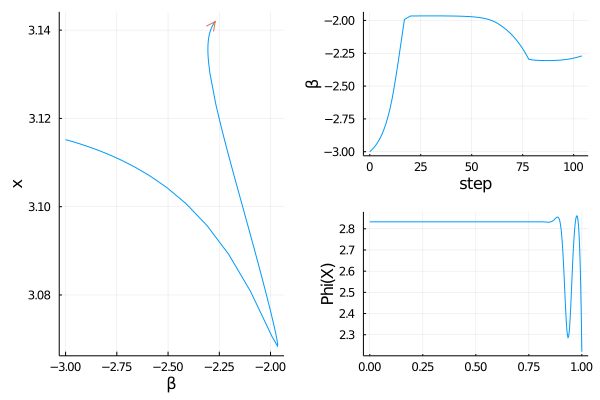

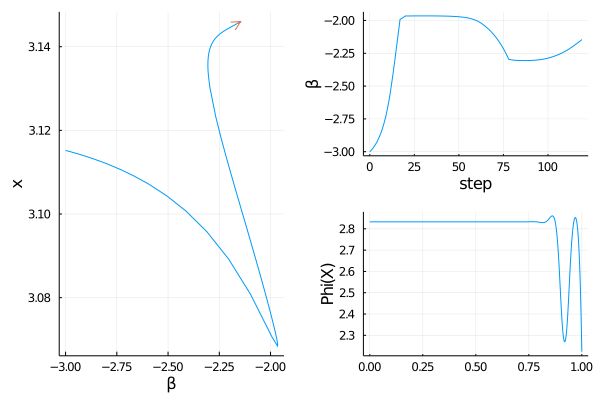

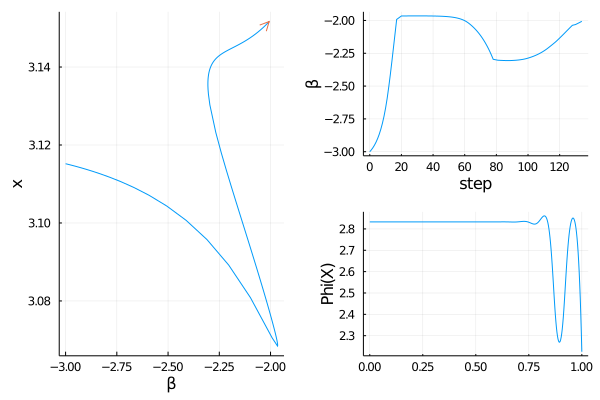

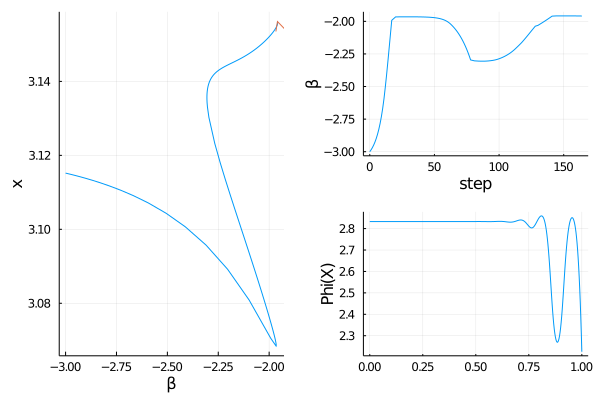

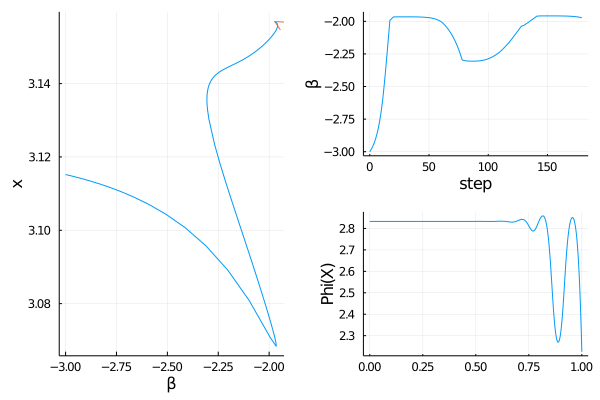

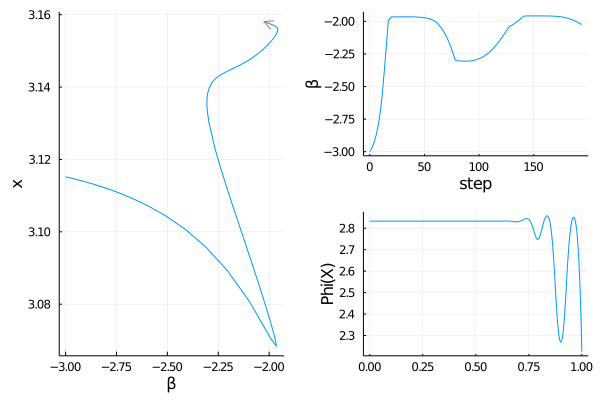

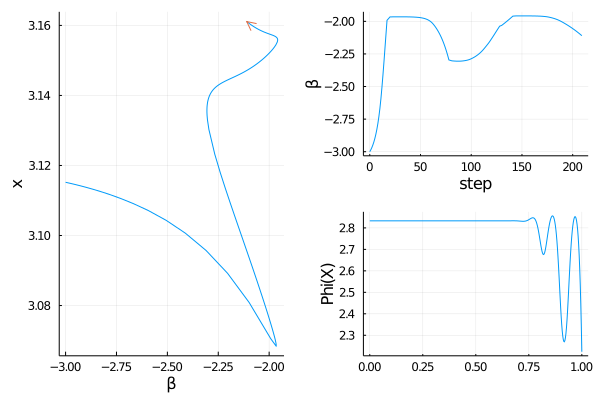

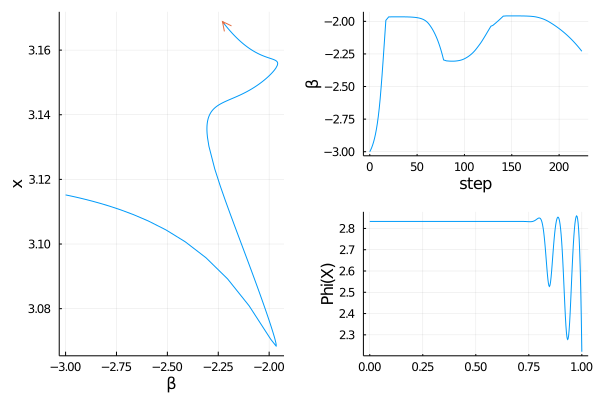

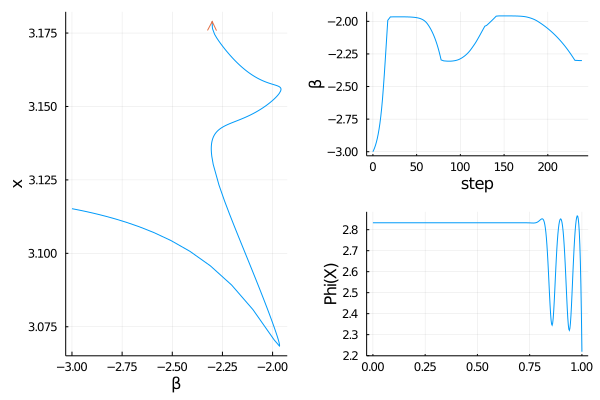

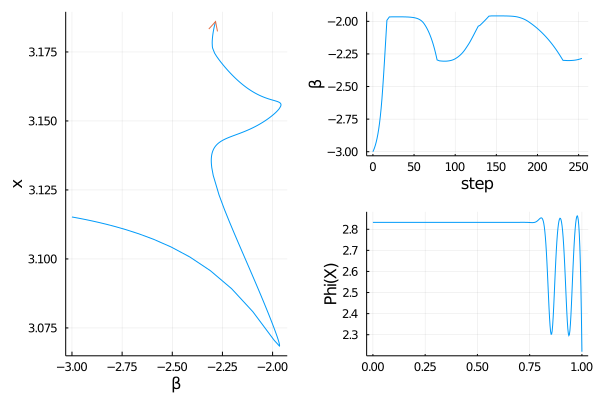

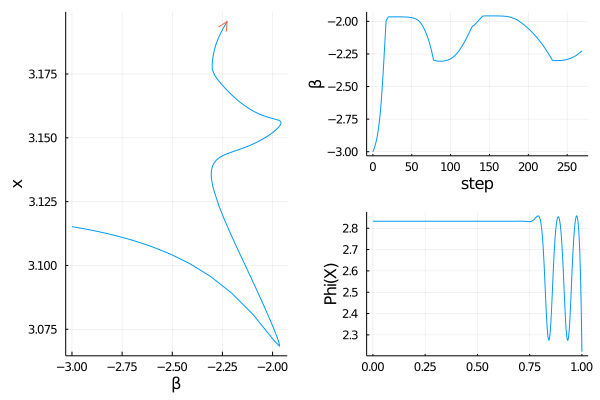

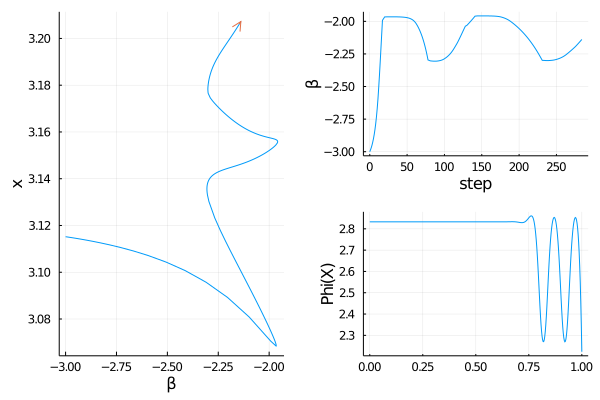

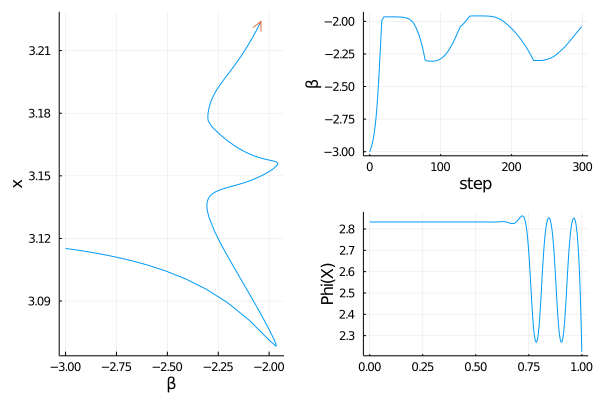

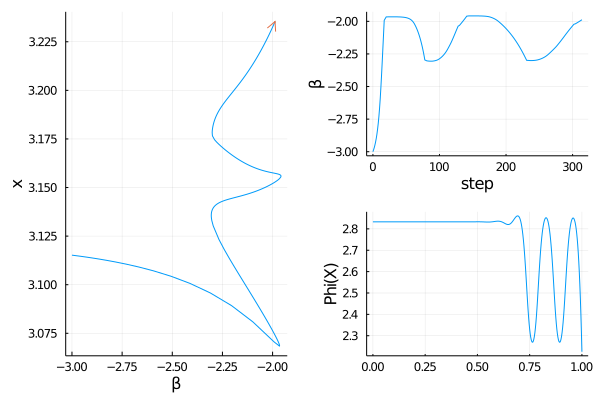

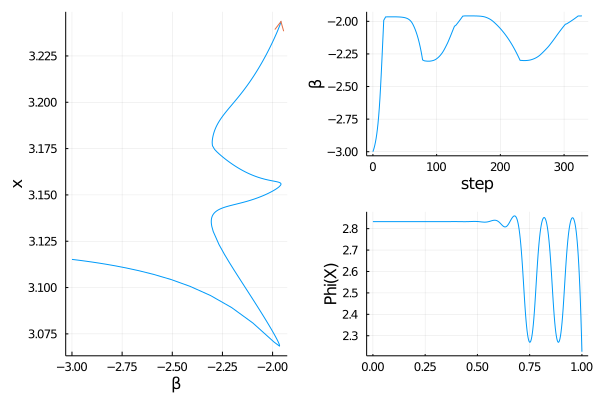

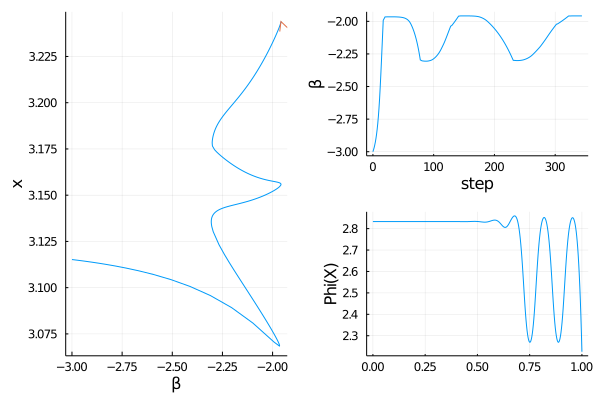

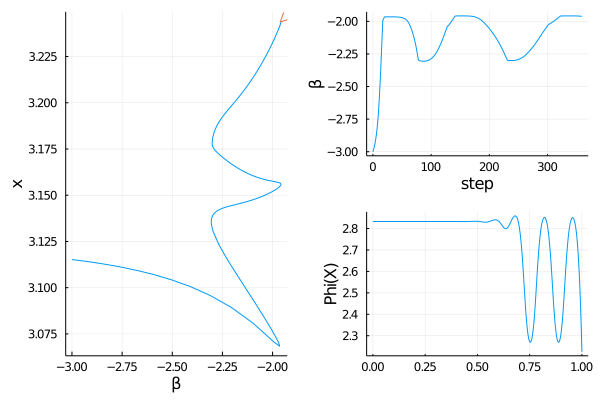

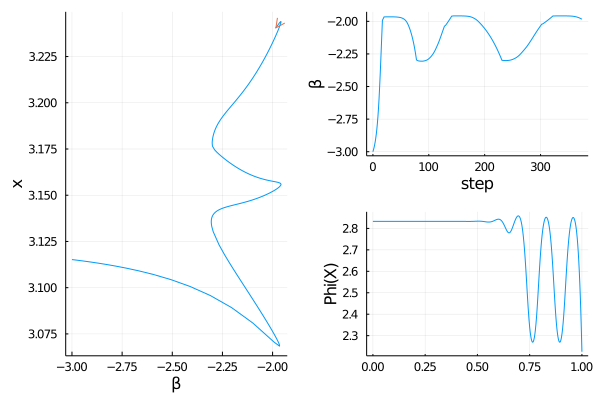

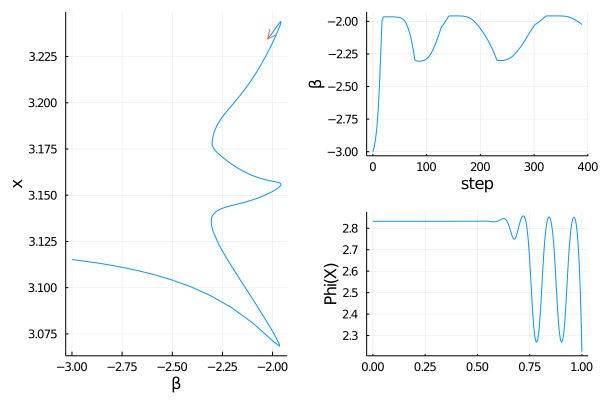

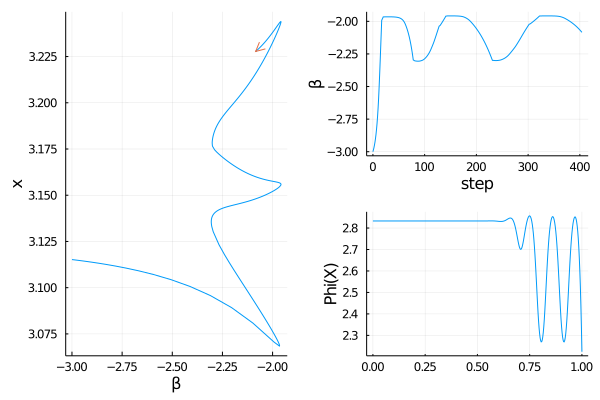

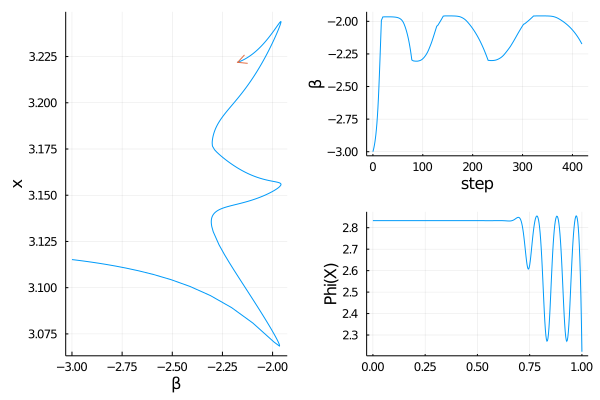

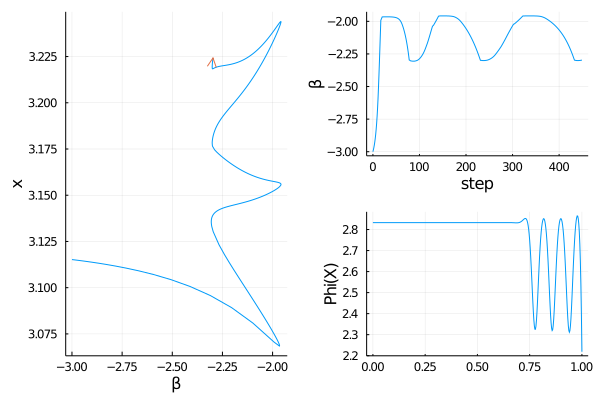

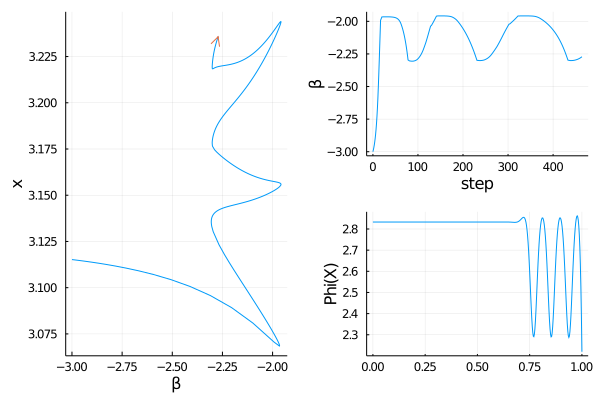

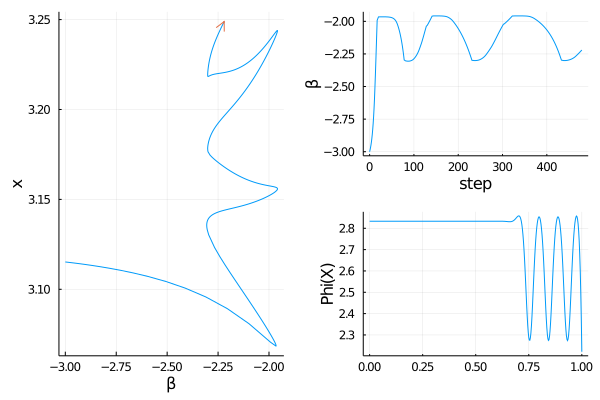

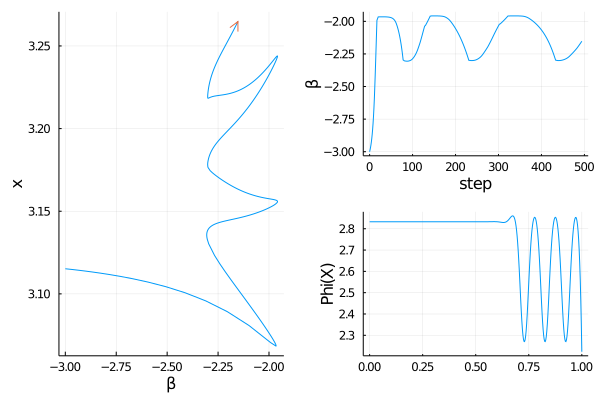

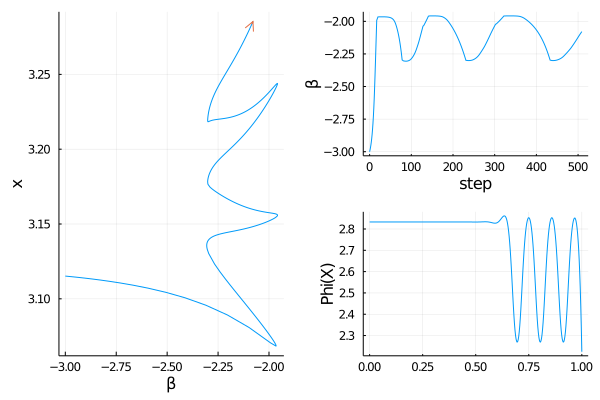

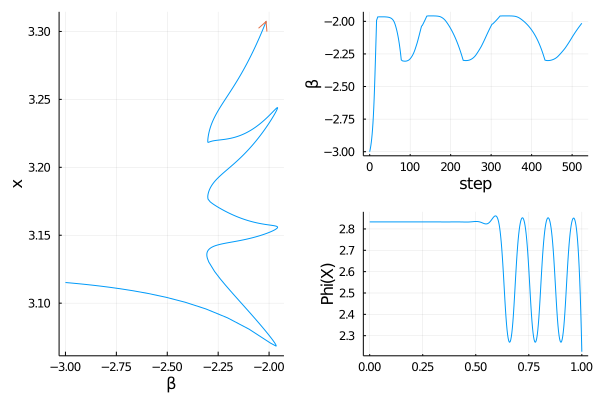

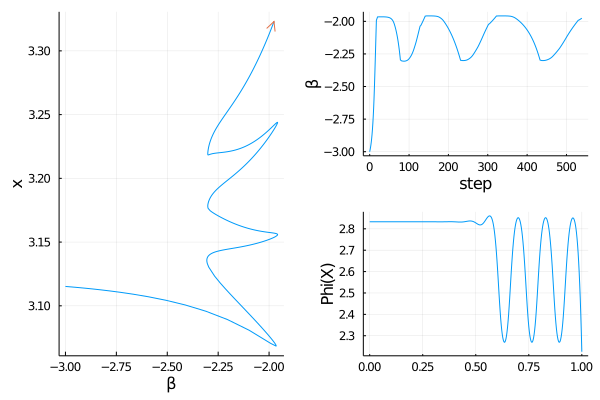

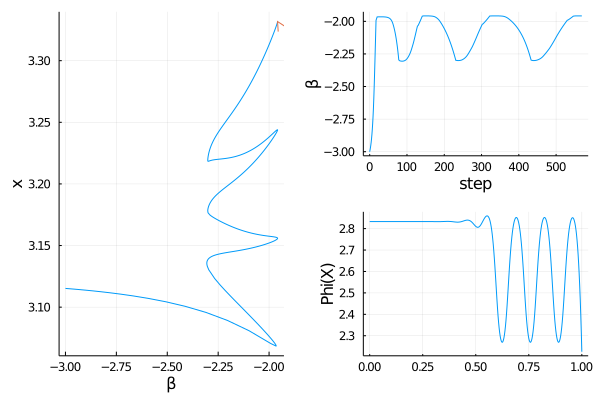

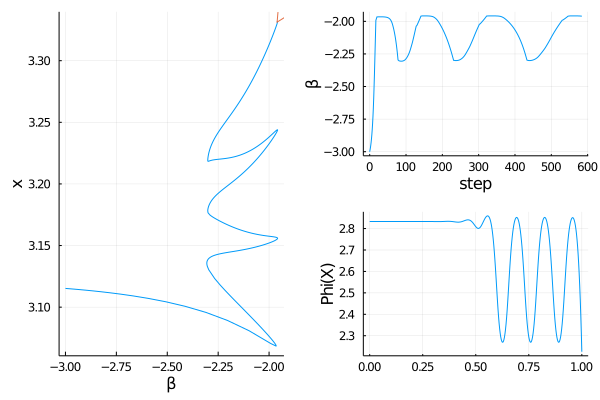

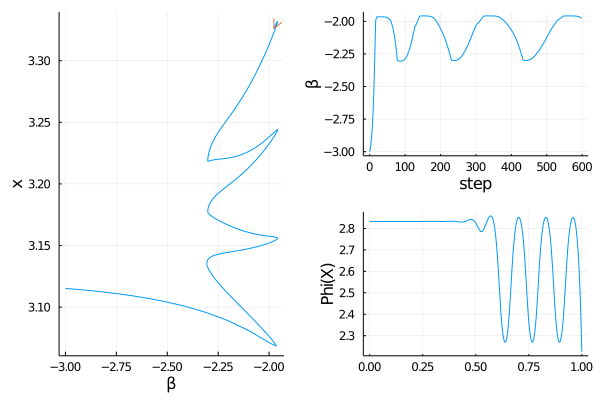

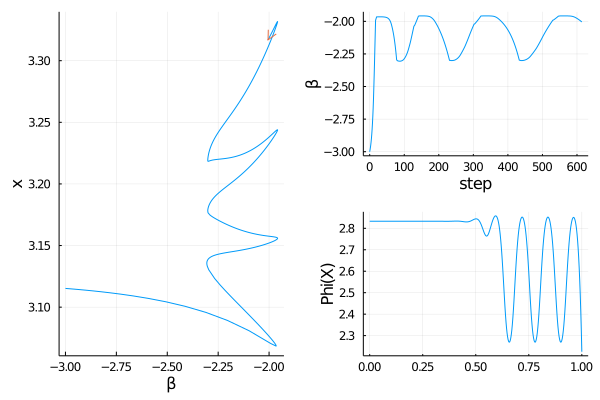

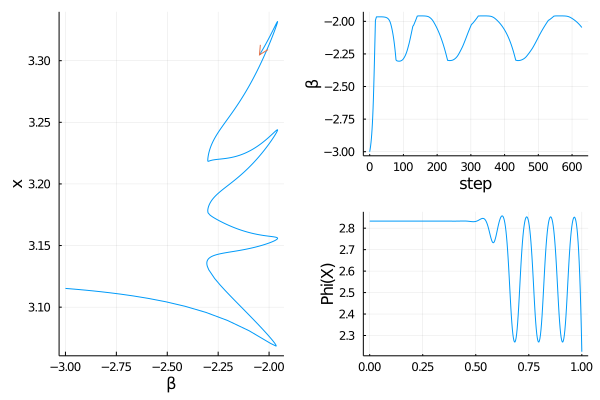

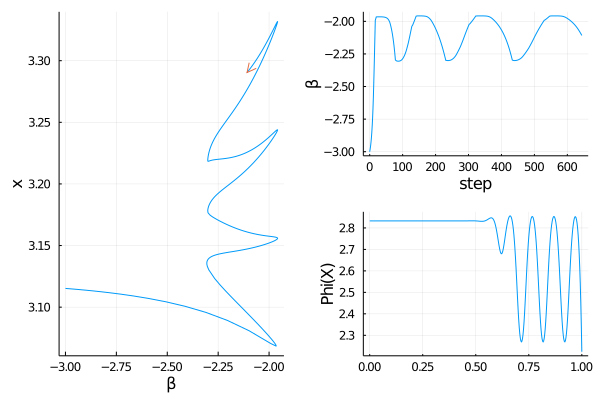

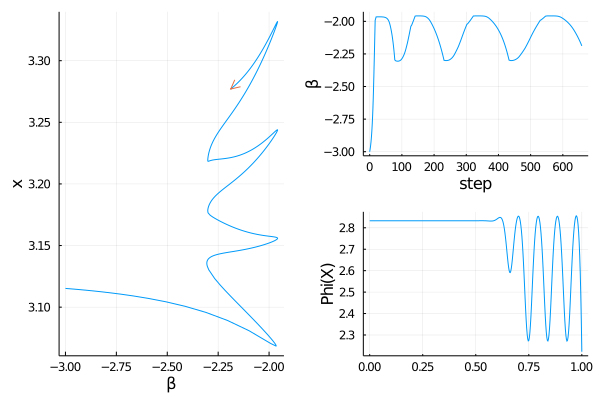

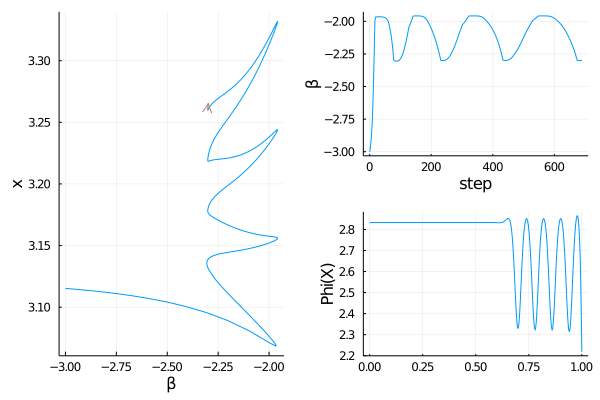

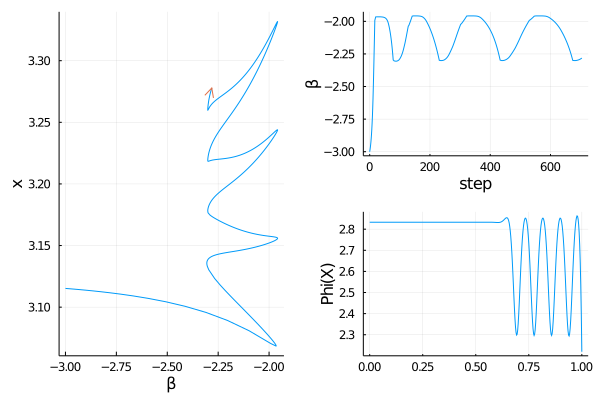

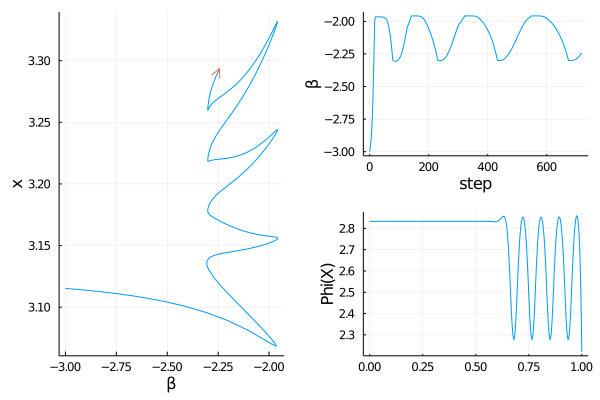

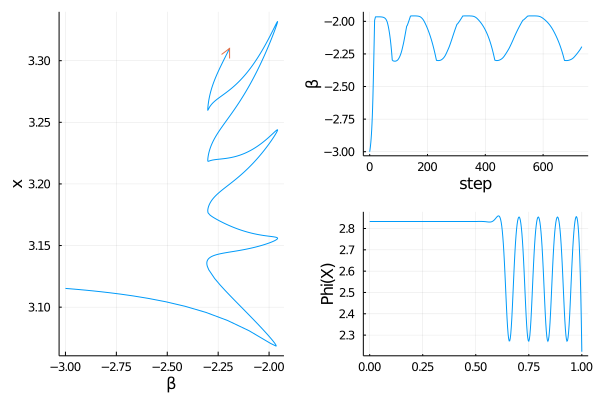

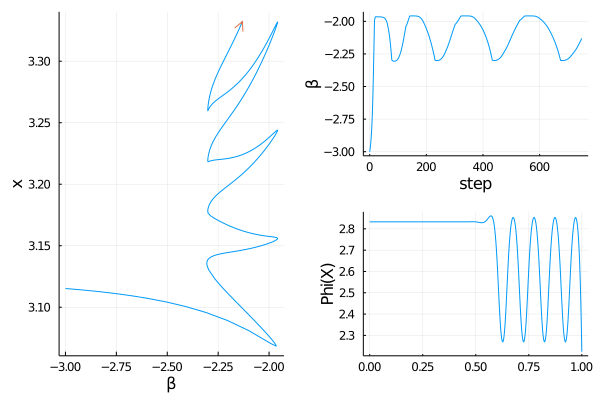

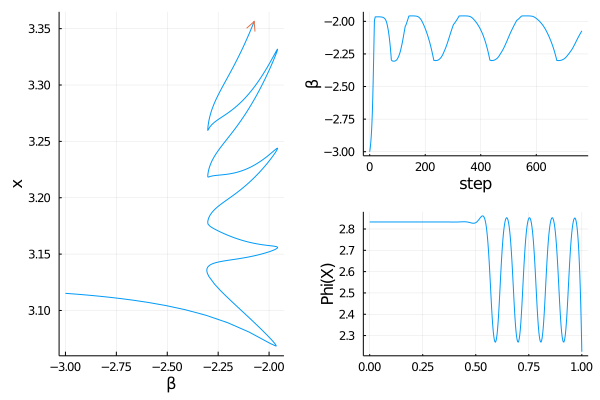

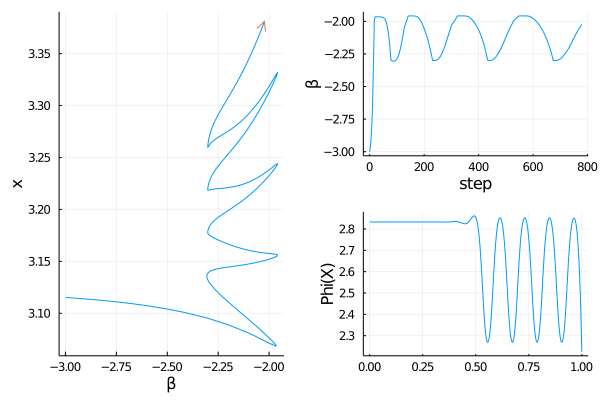

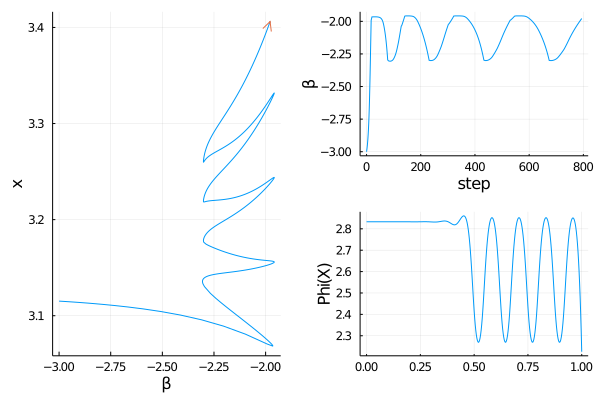

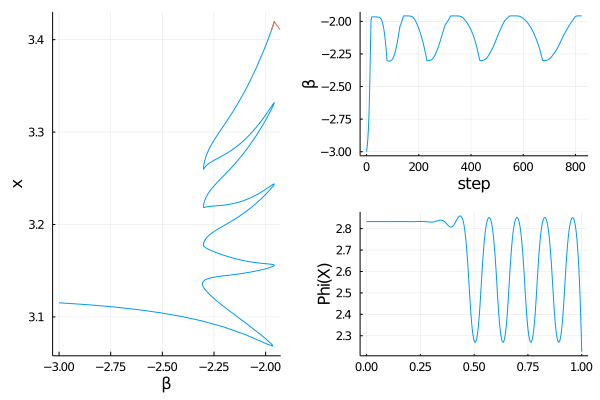

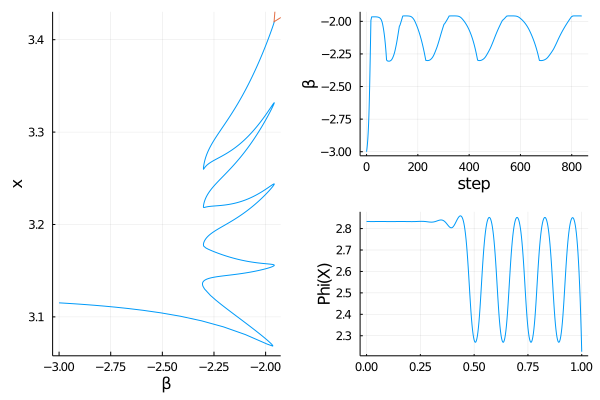

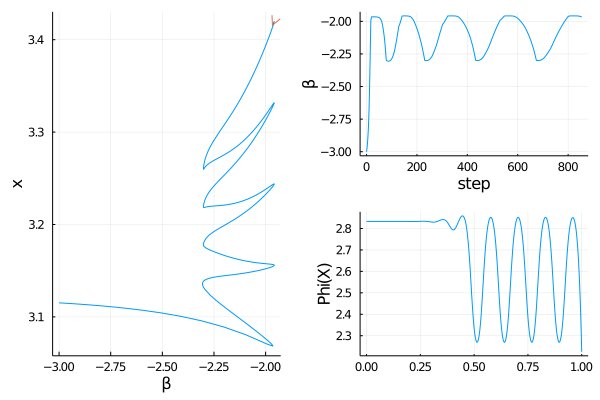

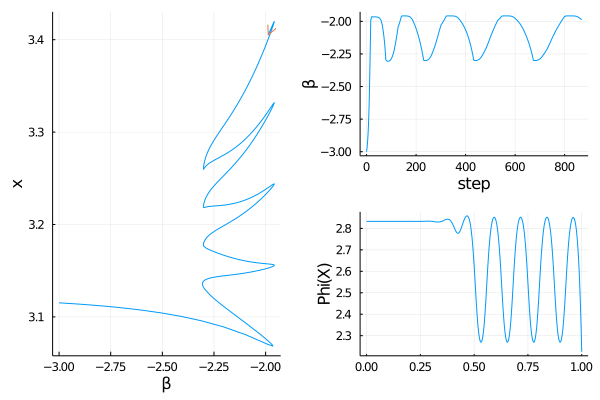

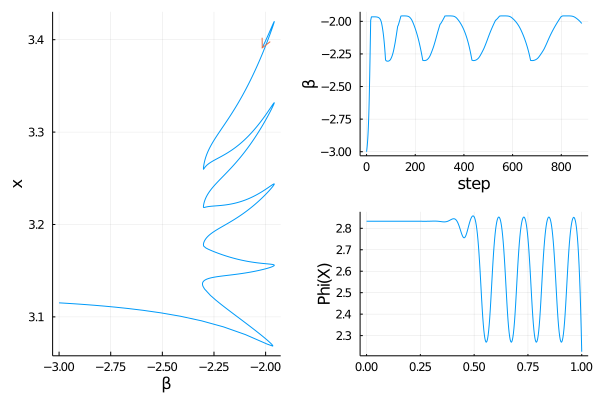

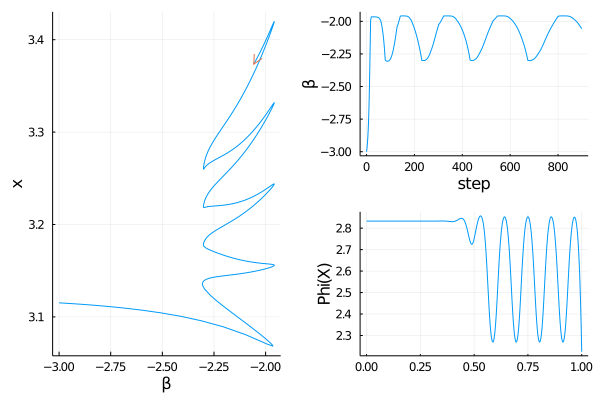

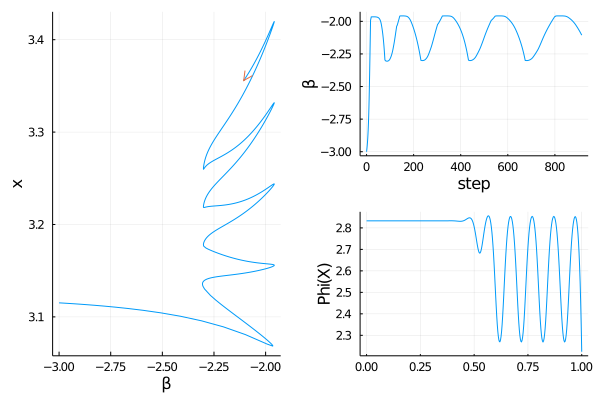

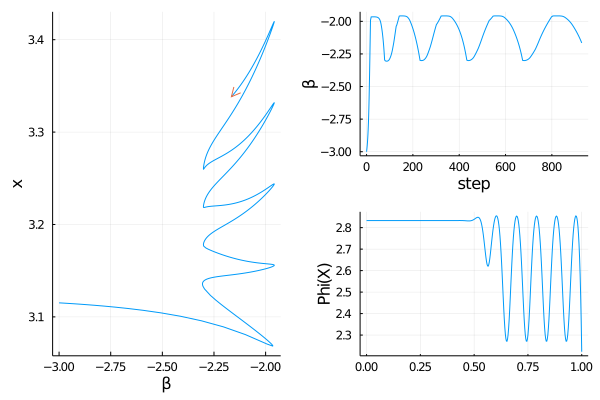

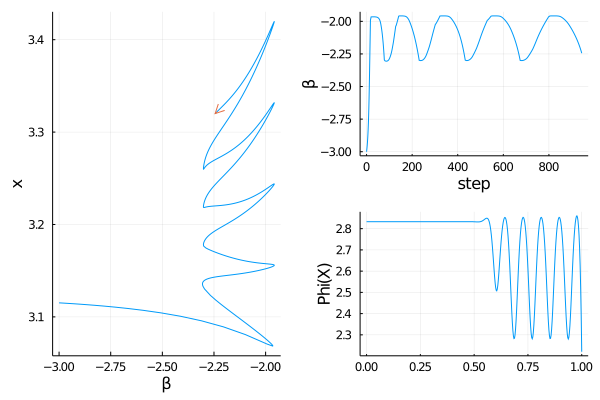

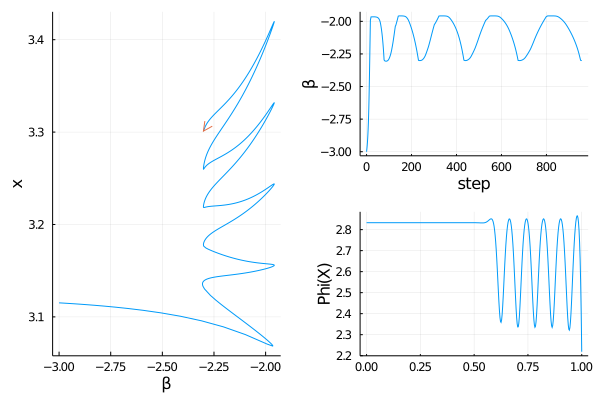

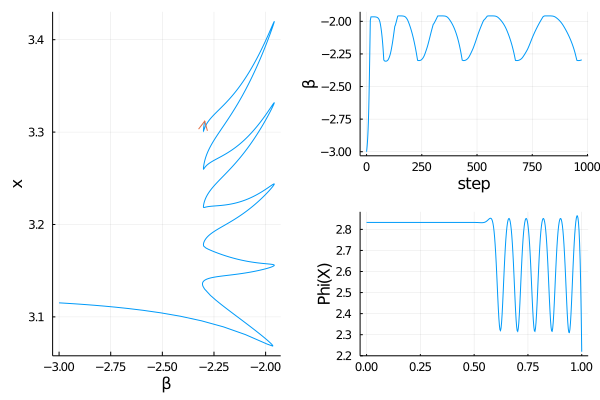

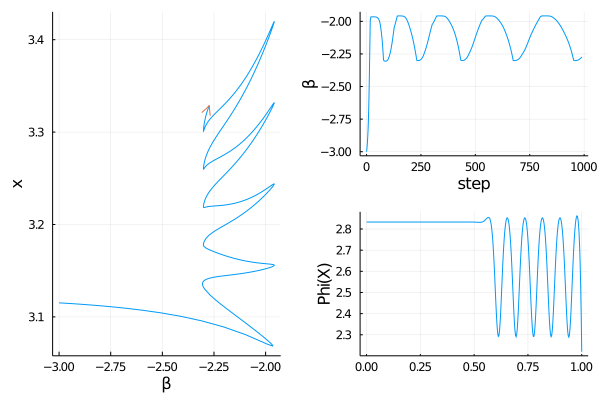

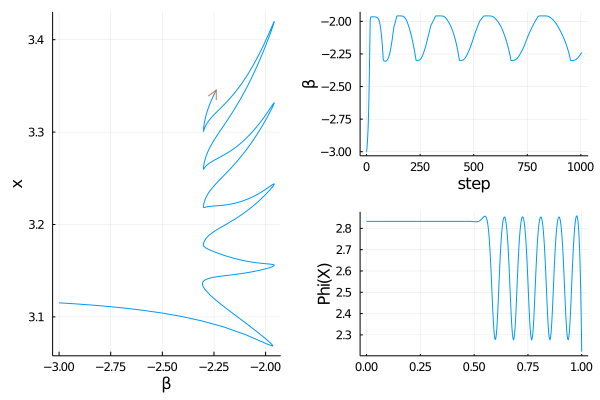

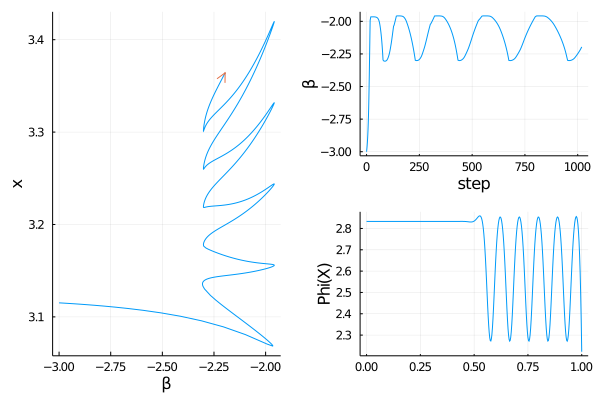

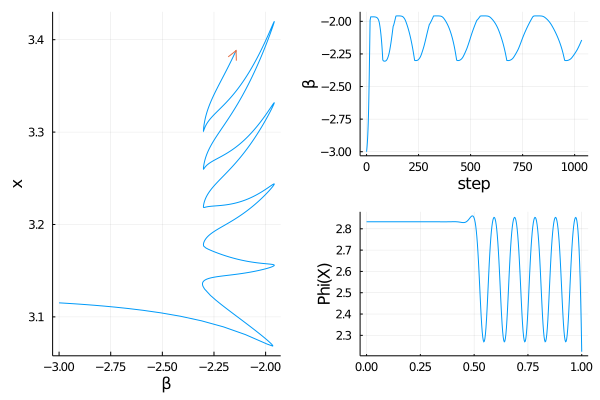

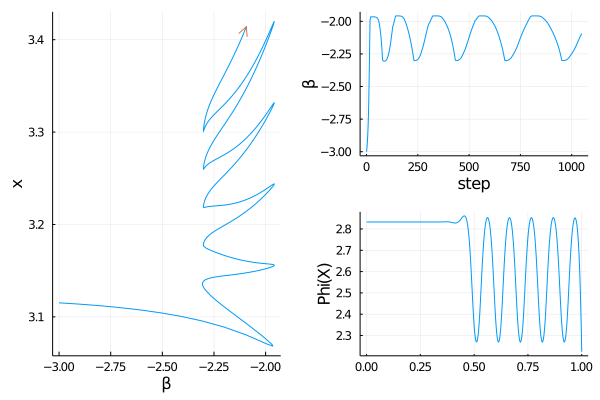

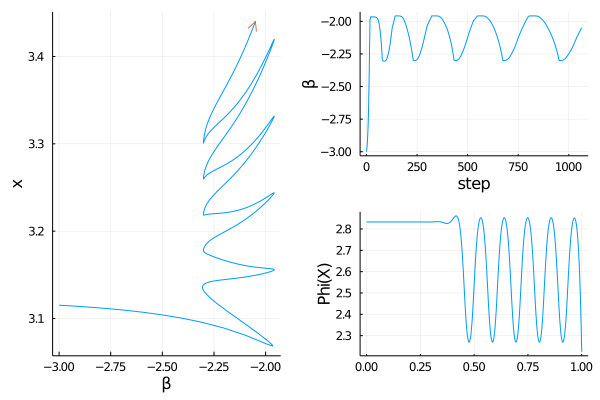

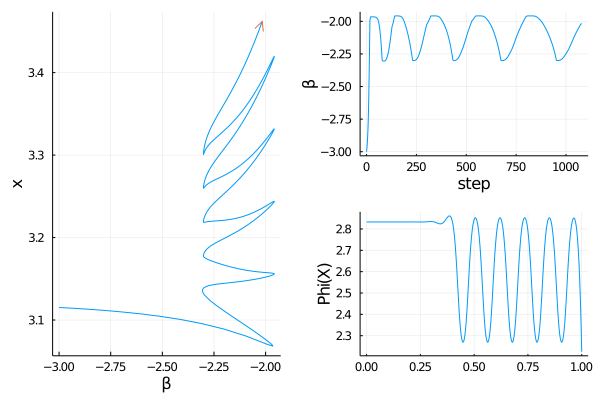

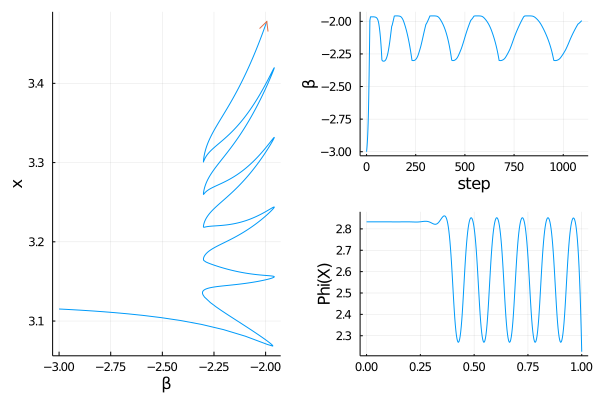

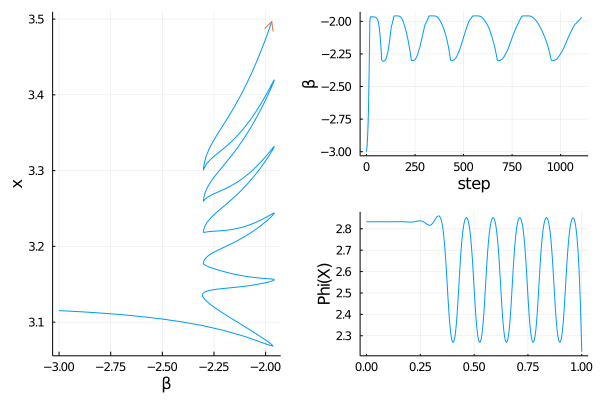

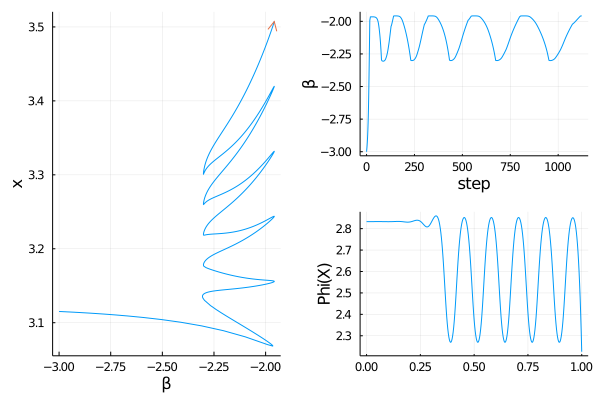

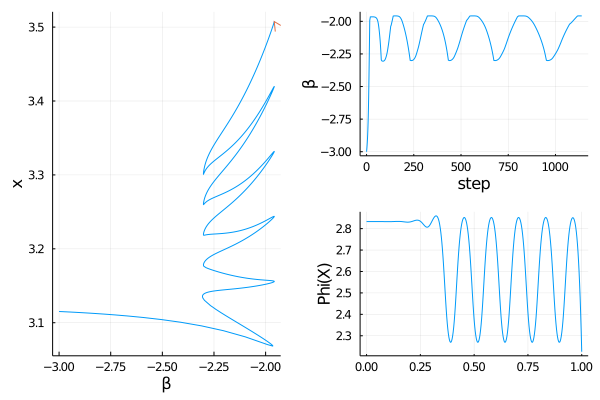

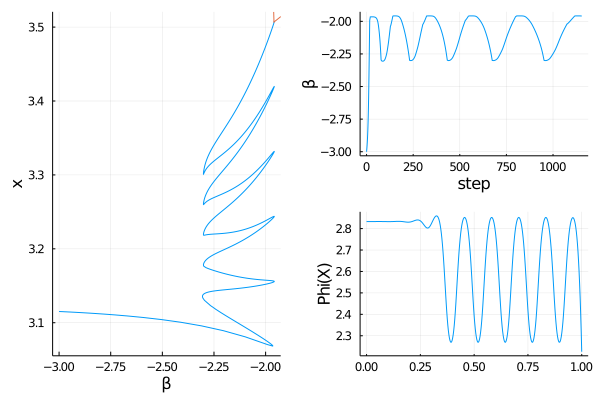

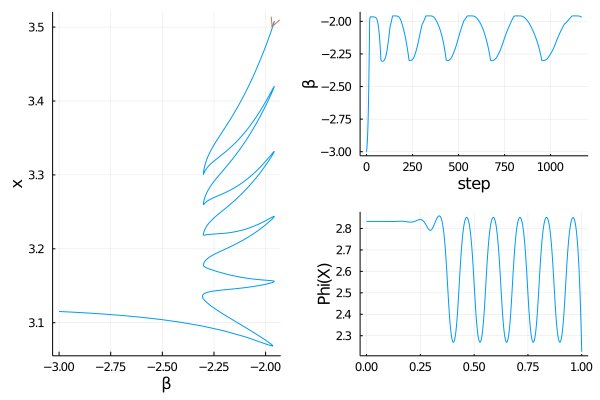

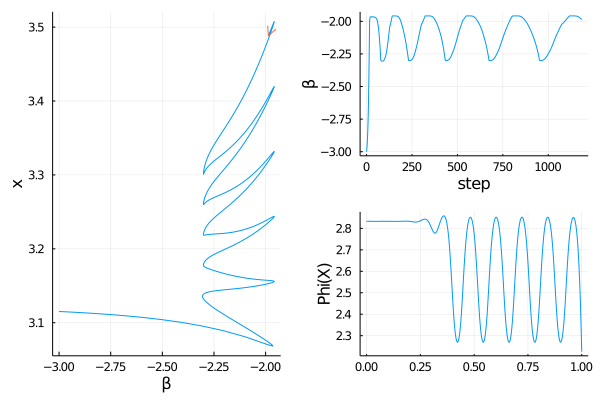

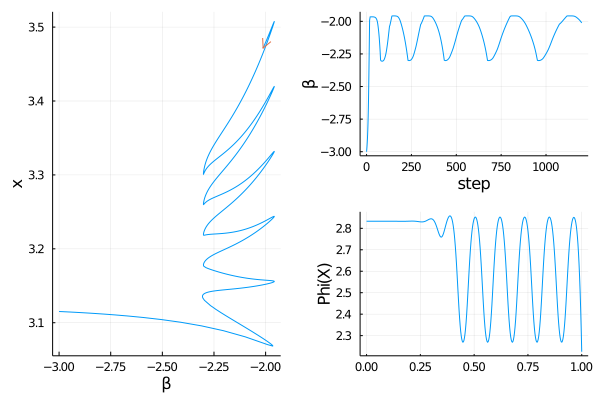

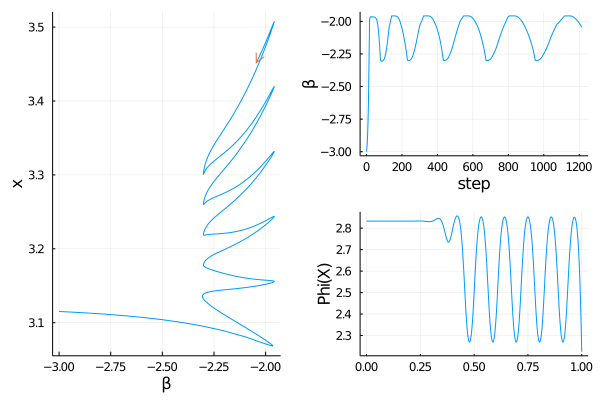

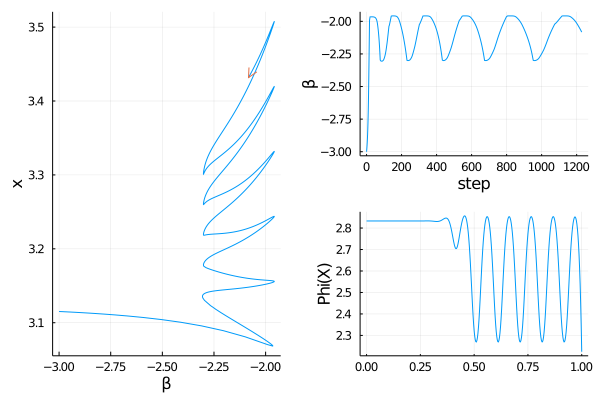

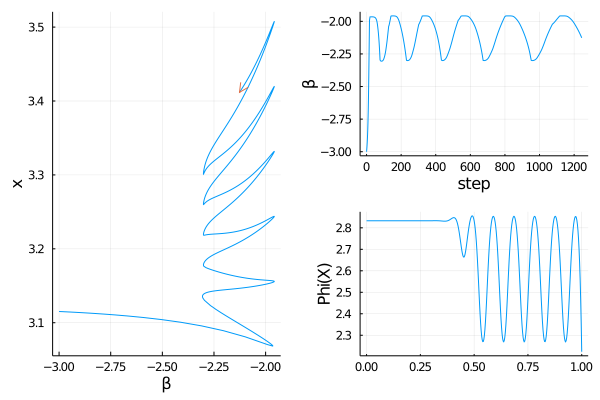

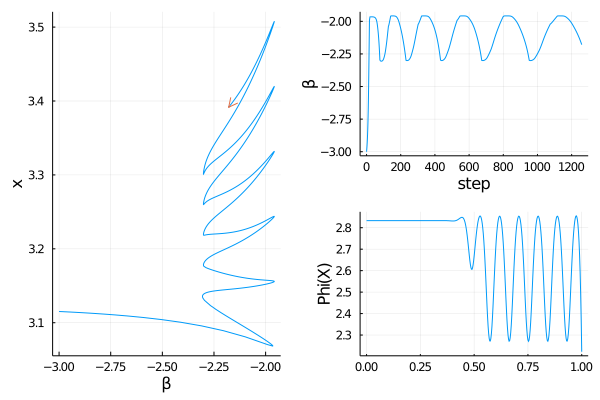

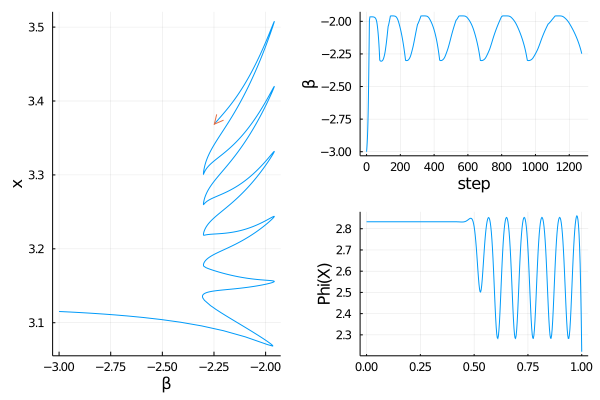

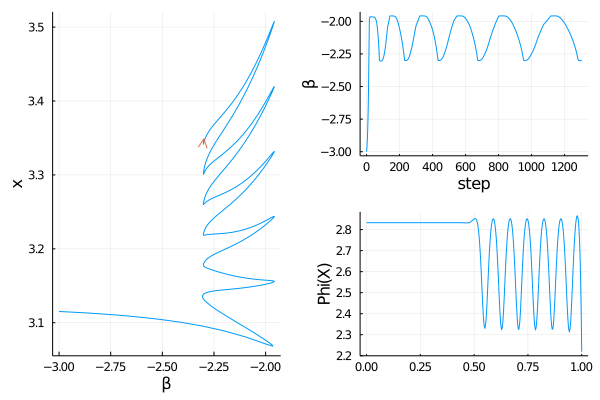

In [ ]:
opt_newton = NewtonPar(tol = 1e-10, verbose =false, maxIter = 5)
opts_br = ContinuationPar(dsmin=0.00001,dsmax=0.075,ds=0.01, pMin=-5.0,pMax=0.5,maxSteps=4000,detectBifurcation=0,
    nev = 4,  newtonOptions = opt_newton,saveSolEveryStep=1,plotEveryStep = 15,precisionStability=1e-12, 
    nInversion= 4, dsminBisection = 1e-8, maxBisectionSteps = 50);

brB, _ = BK.continuation(Fun,out,par_mod, (@lens _.β), opts_br;
    plotSolution = (x, p; kwargs...) -> plot!(XX,x[2*Nx+3:3*Nx+3]; ylabel = "Phi(X)",legend = false, kwargs...),
    printSolution = (x, p) -> height(x),
    normC = x -> norm(x, Inf),
    plot = true);

Storing of the solution and diagram

In [17]:
first=true
phis=Vector{Float64}()
J=Vector{Float64}()
Phi=Vector{Float64}()
H=Vector{Float64}()
Q=Vector{Float64}()
parβ=Vector{Float64}()
for el in brB.sol
    append!(parβ,el.p)
    append!(H,height(el.x))
    if first
        phis=el.x[1:Nx+1]
        J=el.x[Nx+2:2*Nx+2]
        Phi=el.x[2*Nx+3:3*Nx+3]
        Q=totalcharge(el.x,Nx,par_mod.par)
        first=false
    else  
        phis=hcat(phis,el.x[1:Nx+1])
        J=hcat(J,el.x[Nx+2:2*Nx+2])
        Phi=hcat(Phi,el.x[2*Nx+3:3*Nx+3])
        Q=hcat(Q,totalcharge(el.x,Nx,par_mod.par))
    end
end

    

In [19]:
M=hcat(parβ,H)
dir="BifDiagrams/output3/"
using DelimitedFiles
open(dir*"data_diagram.txt","w") do io
    writedlm(io,M,',')
end;
open(dir*"phis.txt","w") do io
    writedlm(io,phis,',')
end;
open(dir*"J.txt","w") do io
    writedlm(io,J,',')
end;
open(dir*"Phi.txt","w") do io
    writedlm(io,Phi,',')
end;
open(dir*"Q.txt","w") do io
    writedlm(io,Q,',')
end;